In [14]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
%autoreload 2

In [16]:
import os
import sys
from datetime import datetime
import time

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import cvxopt
import random
    
aeq_dir = "/mnt/c/Users/jan.zill/code/aequilibrae"
sys.path.append(aeq_dir)
from aequilibrae.paths.path_based.cythoncodetest import OpenBenchmark
# import node
# import link
# #import quadraticassignmentcyt
from aequilibrae.paths.path_based import TrafficAssignmentCy

import utils

In [17]:
code_dir = "/mnt/c/Users/jan.zill/code"
tntp_dir = os.path.join(code_dir, "TransportationNetworks_aequilibrae")

In [21]:
%%time
scenario = "Anaheim" #"Berlin-Center" #
num_iters = 5
cvxopt.solvers.options['show_progress'] = False
#cvxopt.solvers.options['maxiters'] = 6 #
cvxopt.solvers.options['abstol'] =1e-11
cvxopt.solvers.options['reltol'] =1e-11
cvxopt.solvers.options['feastol'] =1e-11

print(f"{datetime.now()} - Running scenario {scenario}")

folder = os.path.join(tntp_dir, scenario)

if scenario == "Anaheim":
    link_file =  "Anaheim_net.tntp"
    trip_file =  "Anaheim_trips.tntp"
elif scenario == "Berlin-Center":
    link_file =  "berlin-center_net_clean.tntp" # DUPLICATE NODES REMOVED  "berlin-center_net_clean_bpr_altered.tntp" #
    trip_file =  "berlin-center_trips.tntp"
else:
    raise ValueError(f"Unknown scenario {scenario}")


### Build data structures
bch = OpenBenchmark(folder, link_file, trip_file)
links, nodes, ods, destinations, origins = bch.build_datastructure()
num_links = len(links)
num_nodes = len(nodes)
num_centroids = len(origins)
print(f"{datetime.now()} - num nodes = {len(nodes)}, num links = {len(links)}")

#
### end build ds

### initialise Ass, add ds
t_assignment = TrafficAssignmentCy.TrafficAssignmentCy(links,num_links,num_nodes,num_centroids)
destinations_per_origin = {}
#t = 0
for (o,d) in ods:
    t_assignment.insert_od(o, d, ods[o,d])
    if o not in destinations_per_origin:
        destinations_per_origin[o] = 0
    destinations_per_origin[o] += 1

    
### Ini solution, iter 0
print(f"{datetime.now()} - performing initial solution")
t_assignment.perform_initial_solution()
costs = [t_assignment.get_objective_function()]
gaps = [1] #initial gap, fix to arbitrary value or better compute it
print(f"{datetime.now()} - done, cost = {costs[0]}")

### Iterations
od_path_times = {}
shortest_path_time = 0
opt_setup_time = 0
opt_solv_time = 0
update_time = 0
total_time = 0
for i in range(num_iters):
    print(f"  {datetime.now()} - starting iteration {i}")
    origins = destinations_per_origin.keys()
    for origin in origins:
        t1 = time.time()
        t_assignment.compute_shortest_paths(origin)
        t2 = time.time()
        t_paths = t_assignment.get_total_paths(origin)
        Q,q,A,b,G,h = t_assignment.get_problem_data(origin,destinations_per_origin[origin])
        Am = cvxopt.matrix(A.tolist(), (t_paths, destinations_per_origin[origin]),"d")
        bm = cvxopt.matrix(b.tolist(), (destinations_per_origin[origin],1),"d")
        Qm = cvxopt.matrix(Q.tolist(), (t_paths,t_paths),"d")
        qm = cvxopt.matrix(q.tolist(), (t_paths,1),"d")
        Gm = cvxopt.matrix(G.tolist(), (t_paths,t_paths),"d")
        hm = cvxopt.matrix(h.tolist(), (t_paths,1),"d")
        t3 = time.time()
        solution = cvxopt.solvers.qp(Qm.trans(), qm, Gm.trans(), hm, Am.trans(), bm)["x"]
        t4 = time.time()
        t_assignment.update_path_flows(origin, solution)
        t5 = time.time()
        shortest_path_time += t2 - t1
        opt_setup_time += t3 - t2
        opt_solv_time += t4 - t3
        update_time += t5 - t4
        total_time += t5 - t1
        
    print(f"  {datetime.now()} - solved P(r) for all r and updated path flows")
    print(f"    runtime breakdown: dijkstra = {shortest_path_time:.2f}, opt setup = {opt_setup_time:.2f}, opt solver = {opt_solv_time:.2f}, update = {update_time:.2f}")
    print(f"                       dijkstra = {shortest_path_time/total_time:.0%}, opt setup = {opt_setup_time/total_time:.0%}, opt solver = {opt_solv_time/total_time:.0%}, update = {update_time/total_time:.0%}")
    

    this_cost = t_assignment.get_objective_function()
    costs.append(this_cost)

    od_path_times[i] = {}
    num = 0
    dem = 0
    for (origin,destination) in ods:
        p_times, p_flows = t_assignment.get_path_times(origin, destination)
        # print origin, destination, p_times
        od_path_times[i][origin,destination] = (p_times,p_flows)           
        # gap
        num += sum(p_flows)*min(p_times)
        for ind in range(len(p_times)):
            dem += p_times[ind]*p_flows[ind]
    gap = 1-num/dem
    gaps.append(gap)
    print(f"  {datetime.now()} - computed path times and flows, computed gap: {gap}, computed objective: {this_cost}")
print(f"{datetime.now()} - Done")

# Collect results
flows = t_assignment.get_link_flows()
t_ = []
for i in range(len(flows)):
    t_.append([links[i].node_id_from+1, links[i].node_id_to+1, flows[i], links[i].get_time(flows[i])])
res_ = pd.DataFrame(data=t_, columns=['a_node', 'b_node', 'flow', 'time'])
print(f"{datetime.now()} - Flows extracted")

2020-12-07 16:58:33.533142 - Running scenario Anaheim
2020-12-07 16:58:33.611736 - num nodes = 416, num links = 914
2020-12-07 16:58:33.616356 - performing initial solution
2020-12-07 16:58:33.639153 - done, cost = 1264524.25
  2020-12-07 16:58:33.639526 - starting iteration 0
  2020-12-07 16:58:33.975721 - solved P(r) for all r and updated path flows
    runtime breakdown: dijkstra = 0.02, opt setup = 0.06, opt solver = 0.23, update = 0.02
                       dijkstra = 5%, opt setup = 19%, opt solver = 69%, update = 6%
  2020-12-07 16:58:33.987573 - computed path times and flows, computed gap: 0.002751810602853011, computed objective: 1208761.5
  2020-12-07 16:58:33.987992 - starting iteration 1
  2020-12-07 16:58:34.346451 - solved P(r) for all r and updated path flows
    runtime breakdown: dijkstra = 0.03, opt setup = 0.14, opt solver = 0.48, update = 0.05
                       dijkstra = 5%, opt setup = 20%, opt solver = 69%, update = 7%
  2020-12-07 16:58:34.359057 - compute

In [11]:
%%time
bfw_res_ = utils.get_assignment_solution(tntp_dir, scenario, link_file, block_centroids=False, rgap=5*1e-5)

CPU times: user 13.7 s, sys: 688 ms, total: 14.4 s
Wall time: 5.74 s


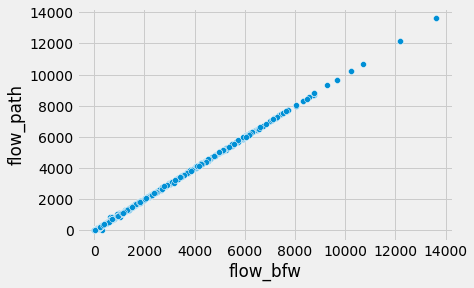

max diff in flow = 271.3635144316306
max rel diff in flow = 0.0


,link_id,a_node,b_node,ff_time,capacity,alpha,beta,direction,flow_bfw,flow_path,abs_change,rel_change
704,704,354,355,1.0,5400,0.15,4,1,304.546982,33.183468,271.363514,0.891040
667,667,342,343,1.0,5400,0.15,4,1,650.530030,830.113525,179.583495,0.276057
706,706,355,343,2.0,5400,0.15,4,1,1017.598121,868.244873,149.353248,0.146770
758,758,370,371,1.0,5400,0.15,4,1,925.147365,1047.161621,122.014256,0.131886
760,760,371,355,2.0,5400,0.15,4,1,713.051139,835.061462,122.010324,0.171110


In [12]:
d_ = bfw_res_.rename(columns={'time': 'ff_time'}).merge(res_.drop(columns=['time']), on=['a_node', 'b_node'], how='outer', suffixes=['_bfw', '_path'])
#d_ = d_.drop(columns=['time_old', 'time_new'])
sns.scatterplot(data=d_, x='flow_bfw', y='flow_path');
plt.show();
d_['abs_change'] = np.abs(d_.flow_bfw - d_.flow_path)
d_['rel_change'] = d_['abs_change'] / d_['flow_bfw']
print(f"max diff in flow = {d_['abs_change'].max()}")
print(f"max rel diff in flow = {d_['rel_change'].min()}")
d_.sort_values(by=['abs_change'], ascending=False).head(5)

In [13]:
d_.sort_values(by=['abs_change'], ascending=False).head(20)

,link_id,a_node,b_node,ff_time,capacity,alpha,beta,direction,flow_bfw,flow_path,abs_change,rel_change
704,704,354,355,1.000000,5400,0.15,4,1,304.546982,33.183468,271.363514,0.891040
667,667,342,343,1.000000,5400,0.15,4,1,650.530030,830.113525,179.583495,0.276057
706,706,355,343,2.000000,5400,0.15,4,1,1017.598121,868.244873,149.353248,0.146770
758,758,370,371,1.000000,5400,0.15,4,1,925.147365,1047.161621,122.014256,0.131886
760,760,371,355,2.000000,5400,0.15,4,1,713.051139,835.061462,122.010324,0.171110
702,702,354,342,2.000000,5400,0.15,4,1,988.982204,1093.242554,104.260349,0.105422
756,756,370,354,2.000000,5400,0.15,4,1,1121.615256,1023.477844,98.137412,0.087497
845,845,394,393,0.140152,5400,0.15,4,1,3163.161190,3070.333008,92.828182,0.029347
838,838,392,391,0.420076,5400,0.15,4,1,1409.428345,1326.485229,82.943115,0.058849
841,841,393,392,0.420076,5400,0.15,4,1,1409.428345,1326.485229,82.943115,0.058849


# step by step replacement

In [ ]:
initialise_data_structures()